In [8]:
import pandas as pd
from datetime import datetime
import tweepy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

print('tweepy version : ', tweepy.__version__)

tweepy version :  4.9.0


### 1. Define Client and Get Tweet Function

I worked with Twitter API v2 and Tweepy library, and I heard from many people about the advantage of using them to get the data. Do not expect any advanced method here (like topic modeling or sentiment analysis), maybe we will cover it sometime in the next post. Initially, I am quite amazed that with this API, we can gather the context of each tweet using Context Annotation, but unfortunately, many tweets have no value in it, so I decided not to use this feature yet.

In [3]:
client = tweepy.Client(bearer_token=' ')

def get_tweet(username, max_result, end_time='2022-09-23T15:01:23+00:00'):
  user_id = client.get_user(username = username).data.id
  my_tweets = client.get_users_tweets(  id = user_id,
                                        max_results=max_result, 
                                        start_time=None, 
                                        end_time=end_time, 
                                        exclude=['retweets', 'replies'],
                                        expansions='author_id', 
                                        user_fields=['id', 'username', 'verified', 'public_metrics'], 
                                        tweet_fields=['author_id','public_metrics', 'created_at', 'lang', 'context_annotations'],
                                        poll_fields=None, 
                                        media_fields=None, 
                                        place_fields=None,
                                        pagination_token=None, 
                                        since_id=None, 
                                        until_id=None, 
                                        user_auth=False)
  tweet_info_ls = []
  i = 0
  for tweet in my_tweets.data:
    tweet_info = {
        'tweet_id': i,
        'id': tweet.id,
        'author_id': tweet.author_id,
        'created_at': tweet.created_at,
        'text': tweet.text, 
        'lang': tweet.lang,
        'retweet': tweet.public_metrics['retweet_count'],
        'quote': tweet.public_metrics['quote_count'],
        'reply': tweet.public_metrics['reply_count'],
        'like': tweet.public_metrics['like_count'],
        'total_engagement': tweet.public_metrics['retweet_count'] + tweet.public_metrics['quote_count'] + tweet.public_metrics['reply_count'] + tweet.public_metrics['like_count'],
        'context_annotations': tweet.context_annotations
    }
    tweet_info_ls.append(tweet_info)
    i = i + 1

  tweets_df = pd.DataFrame(tweet_info_ls)

  user_info_ls = []

  for user in my_tweets.includes['users']:
    user_info = {
        'id': user.id,
        'username': user.username,
        'verified': user.verified,
        'follower_count': user.public_metrics['followers_count'],
        'following_count': user.public_metrics['following_count'],
        'tweet_count': user.public_metrics['tweet_count'],
    }
    user_info_ls.append(user_info)

  users_df = pd.DataFrame(user_info_ls)
  
  return (tweets_df, users_df)

### 2. Get the dataset into a dataframe

Some specifications that I use to gather the dataset:
- Look for 100 newest tweets, with the latest date being September 23, 2022.
- Exclude retweets and replies.
- Extract public metrics of each tweet including the number of retweet, quote retweet, reply, and like.
- Each tweet has an original ID but it consists of a long number. To simplify this, we generate a new shorter ID.

In [19]:
murz_tweets_df, users_df = get_tweet(username = 'ecommurz', max_result = 100)
murz_tweets_df.head()

,tweet_id,id,author_id,created_at,text,lang,retweet,quote,reply,like,total_engagement,context_annotations
0,0,1573326663731093504,1455851745142132741,2022-09-23 15:01:22+00:00,"""Gamau kerja di startup nanti kena layoff"" htt...",in,728,324,153,2643,3848,[]
1,1,1573002796319657984,1455851745142132741,2022-09-22 17:34:26+00:00,"Nevermind, all solved after Google Play update!",en,0,0,0,1,1,"[{'domain': {'id': '30', 'name': 'Entities [En..."
2,2,1573000253145370624,1455851745142132741,2022-09-22 17:24:19+00:00,00.22 ITS FIXED. But experience kinda weird es...,en,0,0,2,6,8,[]
3,3,1572998731334811650,1455851745142132741,2022-09-22 17:18:17+00:00,00.16: Idk if this is my connection or what bu...,en,1,0,1,4,6,"[{'domain': {'id': '47', 'name': 'Brand', 'des..."
4,4,1572997746612895744,1455851745142132741,2022-09-22 17:14:22+00:00,00.12 Android app running well... for about 10...,en,3,2,3,13,21,"[{'domain': {'id': '46', 'name': 'Business Tax..."


Date and time trasnformation for further analysis.

In [7]:
murz_tweets_df[['date', 'hour']] = murz_tweets_df['created_at'].astype(str).str.split(expand=True)
murz_tweets_df[['hour', 'timezone']] = murz_tweets_df['hour'].str.split("+",expand=True)

murz_tweets_df['date'] = pd.to_datetime(murz_tweets_df['date'], format='%Y-%m-%d').dt.date
murz_tweets_df['hour'] = pd.to_datetime(murz_tweets_df['hour'], format='%H:%M:%S').dt.time
murz_tweets_df[['id', 'tweet_id', 'created_at', 'text', 'retweet', 'quote', 'reply', 'like']]

,id,tweet_id,created_at,text,retweet,quote,reply,like
0,1573326663731093504,0,2022-09-23 15:01:22+00:00,"""Gamau kerja di startup nanti kena layoff"" htt...",728,324,153,2643
1,1573002796319657984,1,2022-09-22 17:34:26+00:00,"Nevermind, all solved after Google Play update!",0,0,0,1
2,1573000253145370624,2,2022-09-22 17:24:19+00:00,00.22 ITS FIXED. But experience kinda weird es...,0,0,2,6
3,1572998731334811650,3,2022-09-22 17:18:17+00:00,00.16: Idk if this is my connection or what bu...,1,0,1,4
4,1572997746612895744,4,2022-09-22 17:14:22+00:00,00.12 Android app running well... for about 10...,3,2,3,13
...,...,...,...,...,...,...,...,...
95,1553561131498840064,95,2022-07-31 02:00:12+00:00,We are trapped in this MESSY situation cuz som...,26,3,0,132
96,1553337585451552771,96,2022-07-30 11:11:54+00:00,We all know who going to boss that game https:...,74,3,2,153
97,1553286069294342144,97,2022-07-30 07:47:12+00:00,New post about why VPN might not be the answer...,27,0,2,100
98,1553231696568655873,98,2022-07-30 04:11:08+00:00,"I bet their convos like: \n\n""Steam? Website a...",118,10,5,263


### 3. Look at the daily tweet frequency

To get better view on how Ecommurz daily behavior, we create a simple chart to see how often this account post a tweet. 

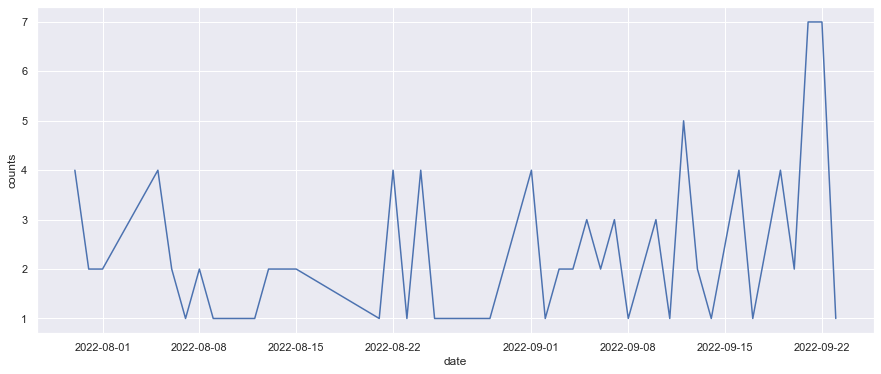

In [10]:
daily_count = murz_tweets_df['date'].value_counts().sort_index().reset_index()
daily_count.columns = ['date', 'counts']

fig, axs = plt.subplots(1,1, figsize = (15,6))
sns.lineplot(ax = axs, data = daily_count, x = 'date', y = 'counts', markers = ['*'])

plt.show()

# Question 1: How are Ecommurz tweets’ characteristics?

First of all, from one hundred tweets, we will look at the distribution of the engagements. Since we only can access the public metrics from the API, in this story I will use the number of retweet, quote retweet, reply and like to represent the engagements on each tweets.

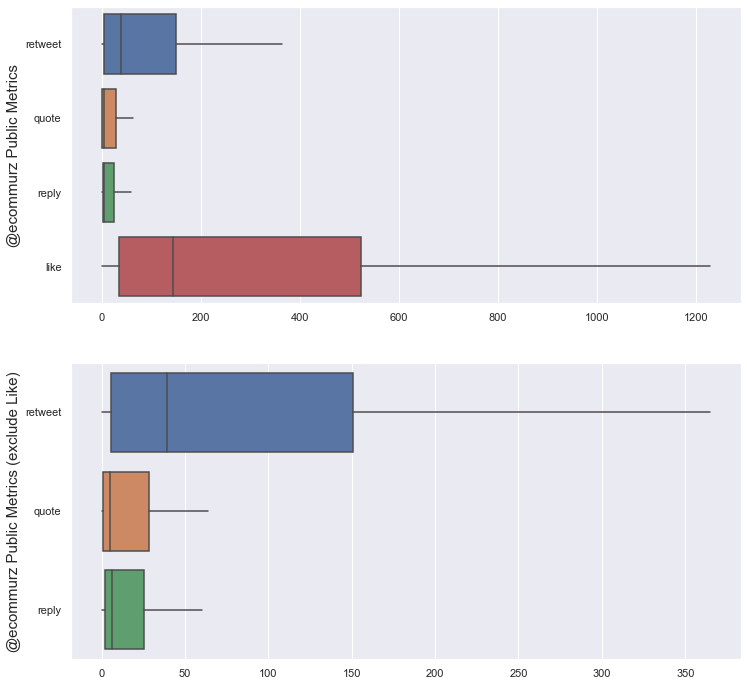

In [11]:
fig_title = "Ecommurz Engagements"

fig, axs = plt.subplots(2,1, figsize = (12,12))
#fig.suptitle(fig_title, fontsize = 20)

tweets_melt = pd.melt(murz_tweets_df, id_vars=['id'], value_vars=['retweet', 'quote', 'reply', 'like'])
sns.boxplot(ax = axs[0], data = tweets_melt, x = 'value', y = 'variable', showfliers = False, showcaps = False )
axs[0].set_xlabel('')
axs[0].set_ylabel('@ecommurz Public Metrics', size = 15)

sns.boxplot(ax = axs[1], data = tweets_melt[tweets_melt['variable'] != 'like'], x = 'value', y = 'variable', showfliers = False, showcaps = False )
axs[1].set_xlabel('')
axs[1].set_ylabel('@ecommurz Public Metrics (exclude Like)', size = 15)

plt.show()

By looking at the first chart above, it is clear we can see that number of like significantly tend to be bigger than other metrics. The consequence is the other metrics will have less contribution if we calculate engagement as the total of these four public metrics. If we remove the like numbers, as you can see in the second chart, we can get more clarity on how is the contribution of each other metrics.

# Question 2: Is this behavior also observed for other popular accounts?

TypeError: 'NoneType' object is not iterable

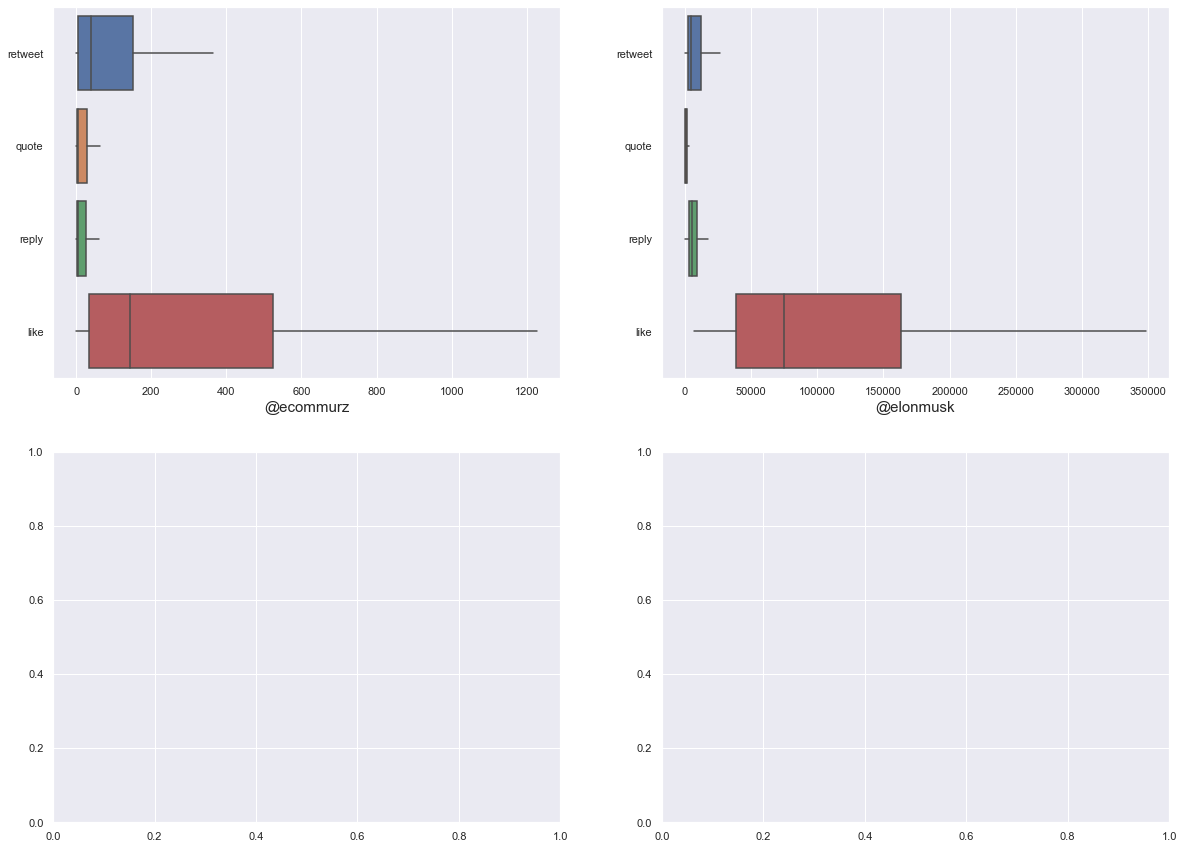

In [14]:
fig_title = 'Engagement Comparison'

max_col = 2
max_row = 2
fig, axs = plt.subplots(max_col,max_row, figsize = (20,15), sharey = False)
# fig.suptitle(fig_title, fontsize = 20)

other_users = ['ecommurz', 'elonmusk', 'hrdbacot', 'idextratime']

j = 0
k = 0
for i in range(0,4):
  tweets_df, users_df = get_tweet(username = other_users[i], max_result = 100)
  tweets_melt = pd.melt(tweets_df, id_vars=['id'], 
                          value_vars=['retweet', 'quote', 'reply', 'like'])
  sns.boxplot(ax = axs[j][k], data = tweets_melt, x = 'value', y = 'variable', showfliers = False, showcaps = False)
  axs[j][k].set_xlabel('@'+other_users[i], size = 15)
  axs[j][k].set_ylabel('')
  k = k + 1
  if k == max_col:
    j = j + 1
    k = 0 
plt.plot()

TypeError: 'NoneType' object is not iterable

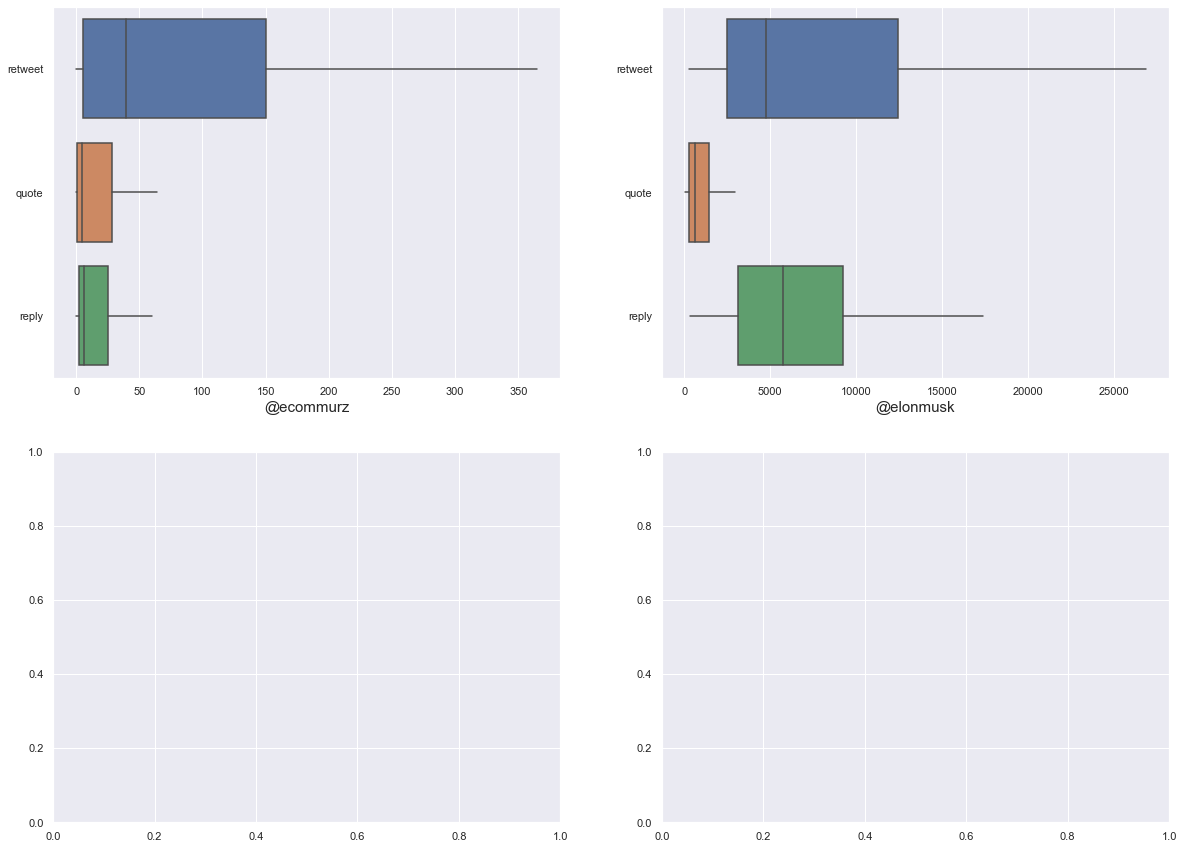

In [15]:
fig_title = 'Engagement Comparison'

max_col = 2
max_row = 2
fig, axs = plt.subplots(max_col,max_row, figsize = (20,15), sharey = False)
# fig.suptitle(fig_title, fontsize = 20)

other_users = ['ecommurz', 'elonmusk', 'hrdbacot', 'idextratime']

j = 0
k = 0
for i in range(0,4):
  tweets_df, users_df = get_tweet(username = other_users[i], max_result = 100)
  tweets_melt = pd.melt(tweets_df, id_vars=['id'], 
                          value_vars=['retweet', 'quote', 'reply', 'like'])
  sns.boxplot(ax = axs[j][k], data = tweets_melt[tweets_melt['variable'] != 'like'], x = 'value', y = 'variable', showfliers = False, showcaps = False)
  axs[j][k].set_xlabel('@'+other_users[i], size = 15)
  axs[j][k].set_ylabel('')
  k = k + 1
  if k == max_col:
    j = j + 1
    k = 0 
plt.plot()

# Question 3: What is the topic of the tweet with the highest number of engagements?

In [20]:
murz_tweets_df['total'] = murz_tweets_df['retweet'] + murz_tweets_df['quote'] + murz_tweets_df['reply']
top15_df = murz_tweets_df[['tweet_id', 'text', 'created_at', 'retweet', 'quote', 'reply', 'total', 'id']].sort_values(by = 'total', ascending = False, ignore_index=True).head(15)
top15_df

,tweet_id,text,created_at,retweet,quote,reply,total,id
0,20,BREAKING: Sad Monday morning. Shopee layoff is...,2022-09-19 05:42:37+00:00,4202,1059,278,5539,1571736498982223872
1,45,"Dear perampok, kalau bisa jangan merampok yha ...",2022-09-06 03:53:57+00:00,3240,1447,788,5475,1566998110177755141
2,43,"BJORKA (THE HACKER) RESPONDED to Kominfo's ""ha...",2022-09-07 03:42:04+00:00,4087,719,381,5187,1567357505440989184
3,49,You know we are in an economic downturn when S...,2022-09-04 13:45:03+00:00,2138,205,95,2438,1566422088138665984
4,52,What an insult for 14-year old kids 😂 https://...,2022-09-03 03:27:39+00:00,1960,153,62,2175,1565904326324654080
5,78,TEAS: Tiket reached &gt;250K amount of page vi...,2022-08-10 06:10:30+00:00,923,805,78,1806,1557248002687143942
6,0,"""Gamau kerja di startup nanti kena layoff"" htt...",2022-09-23 15:01:22+00:00,728,324,153,1205,1573326663731093504
7,48,"BREAKING: Layoffs happening in Garena, just an...",2022-09-05 09:09:04+00:00,713,360,86,1159,1566715022339739649
8,40,TEAS: Several sources said Shopee are cutting ...,2022-09-08 09:38:46+00:00,557,431,158,1146,1567809660790644742
9,50,??????? they are the one asking us to provide ...,2022-09-04 06:37:33+00:00,898,9,34,941,1566314505675493376


Interesting that we have two major categories here. The first one is about layoffs that happening in several companies like Shopee (tweet ID: 20), Garena (46), Zenius (90), and the most recent one Indosat (0). Besides the layoff story, we combine it with the general downturn of the startup that was mostly reported from Shopee and SEA (49, 40, 25, 67).

The second topic is about one of the ministries in the Indonesian government that people love the most. Their new regulation about electronic system providers (PSE) triggers the creation of Gatotkaca (84), the masterpiece that soon will replace Google. And of course, the saga about the data breach and their response (45, 43, 52, 50, 34).
Sadly that we have these two topics dominating our top fifteen tweets, but among them, there is one good news appears Tiket got the highest visit/minute record when they sold Seventeen tickets (78).

Now we will take a deeper look by plotting each tweet in relation charts of quote vs retweet, reply vs retweet, and reply vs quote. Please note that in the following chart we only highlighted the top fifteen tweets with the above two major topics. The first topic (“Layoff Story/Startup Downturn”) will be plotted with orange color, the second topic (“Kominfo/Data Breach”) will get a blue color, and other than that will get grey color. Besides categories, we also make the size of each point represent the number of likes. So the larger the point, the bigger the number of likes.

In [21]:
murz_tweets_df.loc[murz_tweets_df['tweet_id'].isin([20,49,48,0,40,25,67,90]),'category'] = 'Layoff Story/Startup Downturn'
murz_tweets_df.loc[murz_tweets_df['tweet_id'].isin([45,43,52,50,84,34]),'category'] = 'Kominfo/Data Breach'
murz_tweets_df.loc[murz_tweets_df['category'].isna(), 'category'] = 'Other'

top15_list = top15_df['tweet_id']

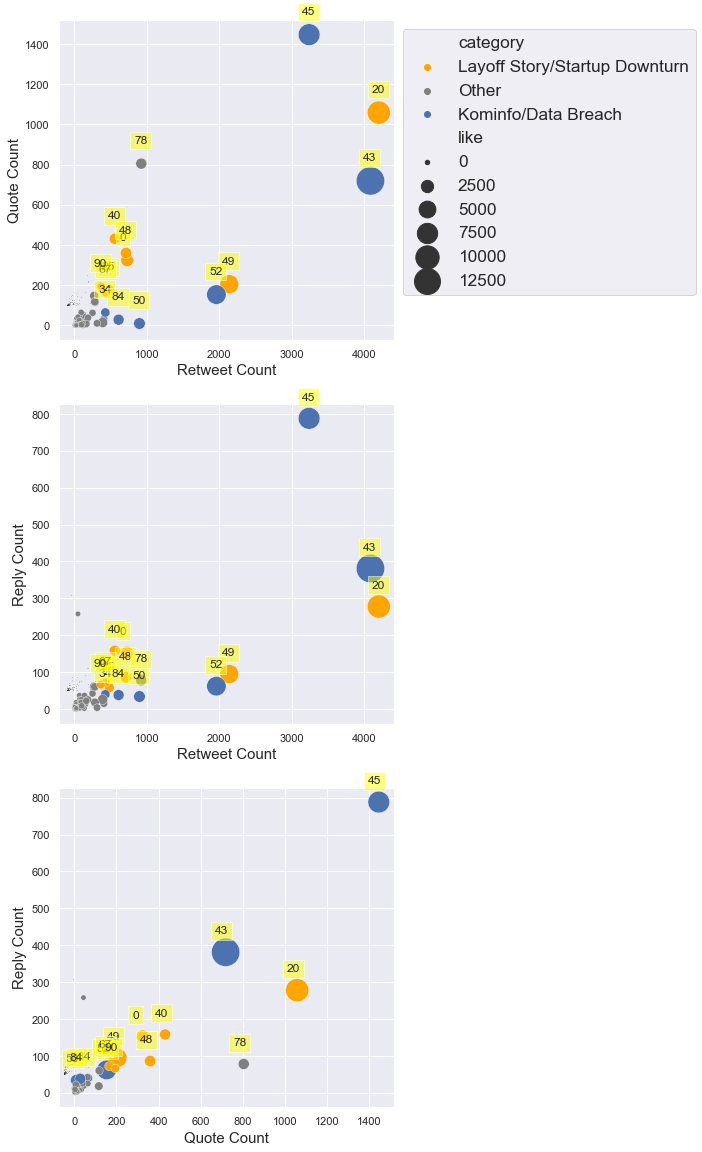

In [23]:
fig_title = 'Engagement Comparison'

fig, axs = plt.subplots(3,1, figsize = (6,20), sharey = False)

import numpy as np
metrics = ['retweet', 'quote', 'reply', 'like', 'total_engagement']

sns.set_color_codes(palette='deep')
palette_dict = {'Layoff Story/Startup Downturn': 'orange', 'Kominfo/Data Breach': 'b', 'Other': 'grey'}
sns.scatterplot(ax = axs[0], data = murz_tweets_df, x = metrics[0], y = metrics[1], size = metrics[3], sizes = (20,800), legend = True, hue = 'category', palette = palette_dict)
sns.scatterplot(ax = axs[1], data = murz_tweets_df, x = metrics[0], y = metrics[2], size = metrics[3], sizes = (20,800), legend = False, hue = 'category', palette = palette_dict)
sns.scatterplot(ax = axs[2], data = murz_tweets_df, x = metrics[1], y = metrics[2], size = metrics[3], sizes = (20,800), legend = False, hue = 'category', palette = palette_dict)

axs[0].set_xlabel('Retweet Count', size=15)
axs[0].set_ylabel('Quote Count', size=15)
axs[1].set_xlabel('Retweet Count', size=15)
axs[1].set_ylabel('Reply Count', size=15)
axs[2].set_xlabel('Quote Count', size=15)
axs[2].set_ylabel('Reply Count', size=15)

def label_point(data, x, y, val, size, ax, offset_x=0, offset_y=0):
    a = pd.concat({'x': data[x], 'y': data[y], 'size': data[size], 'val': data[val]}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+offset_x, point['y']+offset_y, str(point['val']), size = 12 if np.any(point['val'] == top15_list) else 0,
                bbox=dict(facecolor='yellow',alpha= 0.5 if np.any(point['val'] == top15_list) else 0))

label_point( data = murz_tweets_df, x = metrics[0], y = metrics[1], val = 'tweet_id', size = metrics[4], ax = axs[0], offset_x = -100, offset_y = 100)
label_point( data = murz_tweets_df, x = metrics[0], y = metrics[2], val = 'tweet_id', size = metrics[4], ax = axs[1], offset_x = -100, offset_y = 50)
label_point( data = murz_tweets_df, x = metrics[1], y = metrics[2], val = 'tweet_id', size = metrics[4], ax = axs[2], offset_x = -50, offset_y = 50)

axs[0].legend(bbox_to_anchor= (1,1), fontsize='x-large')
plt.show()

As we can see on the above scatter plots, our top three tweets are consistently appear in the top-right quadrant. This means that these three tweets always get highest attention by Murz followers by retweeting, quoting, or replying the tweet.

## Conclusion

We already completed the analysis and got some conclusions:

By comparing with other popular accounts, we understand that number of like always tend to be the largest among public metrics, and the characteristics of each account can be analyzed by looking at the number of the retweet, quote retweet, and reply.
For Ecommurz, the top fifteen tweets that sorted by the combination of three metrics show there are two main topics that attract people to react:
- Data breach issue
- Layoff story and other startup downturn topics

Complete analysis: https://miqbalrp.medium.com/ecommurz-tweet-analysis-between-layoff-and-data-breach-63df50cc89ec